In [ ]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.0 MB/s eta 0:00:00


**Code for simulation**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider


sigma = 0.34  # nm (Lennard-Jones distance parameter)
epsilon = 120 * 1.38e-23  # J (Lennard-Jones energy parameter)
mass = 39.948 * 1.66e-27  # kg (Argon atomic mass)
kb = 1.38e-23  # J/K (Boltzmann constant)
dt = 5e-15  # s (Time step)
num_steps = 1000000  # Total simulation steps

# Compute box size so that its diagonal is equal to the cutoff distance
cutoff = 2.5 * sigma
box_size = cutoff / np.sqrt(3)  # Cube with diagonal = cutoff distance

# Initialize Positions & Velocities

np.random.seed(42)  # For reproducibility

# First atom's initial position
position1 = np.random.uniform(0, box_size, (3,))

# Second atom placed **very close** to the first atom
position2 = position1 + np.random.uniform(0.01, 0.02, (3,))  # Almost overlapping

# Apply PBCs in case the second atom is outside the box
position2 = position2 % box_size

# Initial velocities from Maxwell-Boltzmann distribution
temperature = 300  # K
std_dev = np.sqrt(kb * temperature / mass)
velocity1 = np.random.normal(0, std_dev, (3,)) * 10  # Scaling up velocity
velocity2 = np.random.normal(0, std_dev, (3,)) * 10

# Store trajectories
positions1_list = [position1.copy()]
positions2_list = [position2.copy()]
velocity1_list = [velocity1.copy()]
velocity2_list = [velocity2.copy()]

#Define Functions

def minimum_image_distance(r1, r2, box_size):
    delta_r = r1 - r2
    delta_r -= box_size * np.round(delta_r / box_size)  # Apply PBC
    return delta_r, np.linalg.norm(delta_r)

def lennard_jones_force(r1, r2, box_size):
    """Compute the Lennard-Jones force using the minimum image convention."""
    delta_r, r = minimum_image_distance(r1, r2, box_size)

    if r > cutoff:  # Apply cutoff to reduce computation
        return np.zeros(3), np.zeros(3)

    force_mag = 24 * epsilon * (2 * (sigma / r) ** 12 - (sigma / r) ** 6) / r ** 2
    force = force_mag * delta_r / r
    return force, -force  # Newton's third law: F_1 = -F_2

#Run MD Simulation with Lennard-Jones Forces

for step in range(num_steps):
    # Compute forces
    force1, force2 = lennard_jones_force(position1, position2, box_size)

    # Update positions (Velocity Verlet)
    new_position1 = position1 + velocity1 * dt + 0.5 * (force1 / mass) * dt ** 2
    new_position2 = position2 + velocity2 * dt + 0.5 * (force2 / mass) * dt ** 2

    # Apply Periodic Boundary Conditions (PBCs)
    new_position1 = new_position1 % box_size
    new_position2 = new_position2 % box_size

    # Recompute forces at new positions
    new_force1, new_force2 = lennard_jones_force(new_position1, new_position2, box_size)

    # Update velocities (Velocity Verlet)
    velocity1 += 0.5 * (force1 + new_force1) / mass * dt
    velocity2 += 0.5 * (force2 + new_force2) / mass * dt

    # Store new positions
    positions1_list.append(new_position1.copy())
    positions2_list.append(new_position2.copy())
    velocity1_list.append(velocity1.copy())
    velocity2_list.append(velocity2.copy())

    # Update position references for next iteration
    position1 = new_position1
    position2 = new_position2

# Convert to numpy arrays for visualization
positions1_array = np.array(positions1_list)
positions2_array = np.array(positions2_list)
velocity1_array = np.array(velocity1_list)
velocity2_array = np.array(velocity2_list)

#Visualization with Slider

def plot_trajectory(max_timestep):
    step_size = 10  # Reduce number of points for clarity
    selected_positions1 = positions1_array[:max_timestep:step_size]
    selected_positions2 = positions2_array[:max_timestep:step_size]

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot Atom 1
    ax.plot(selected_positions1[:, 0], selected_positions1[:, 1], selected_positions1[:, 2],
            marker='o', linestyle='-', color='blue', label="Atom 1 Path")

    # Plot Atom 2
    ax.plot(selected_positions2[:, 0], selected_positions2[:, 1], selected_positions2[:, 2],
            marker='o', linestyle='-', color='red', label="Atom 2 Path")

    # Initial positions
    ax.scatter(selected_positions1[0, 0], selected_positions1[0, 1], selected_positions1[0, 2],
               c='b', marker='o', label="Start Atom 1")
    ax.scatter(selected_positions2[0, 0], selected_positions2[0, 1], selected_positions2[0, 2],
               c='r', marker='o', label="Start Atom 2")

    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)
    ax.set_zlim(0, box_size)
    ax.set_xlabel("X Position (nm)")
    ax.set_ylabel("Y Position (nm)")
    ax.set_zlabel("Z Position (nm)")
    ax.set_title(f"Trajectory of Two Argon Atoms (0 to {max_timestep})")
    ax.legend()
    plt.show()

# Interactive Slider
interact(plot_trajectory, max_timestep=IntSlider(min=10, max=num_steps, step=10, value=100));

interactive(children=(IntSlider(value=100, description='max_timestep', max=1000000, min=10, step=10), Output()…

In [ ]:
print(positions1_array.shape)
print(positions2_array.shape)
print(velocity1_array.shape)
print(velocity2_array.shape)

(1000001, 3)
(1000001, 3)
(1000001, 3)
(1000001, 3)


**Training the model**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from ipywidgets import interact, IntSlider

# Constants
sigma = 0.34  # nm (Lennard-Jones distance parameter)
epsilon = 120 * 1.38e-23  # J (Lennard-Jones energy parameter)
mass = 39.948 * 1.66e-27  # kg (Argon atomic mass)
kb = 1.38e-23  # J/K (Boltzmann constant)
dt = 5e-15  # s (Time step)
num_steps = 100000  # Reduced for practical execution
cutoff = 2.5 * sigma  # Lennard-Jones cutoff distance

# Box size (Fixed at 3nm × 3nm × 3nm)
box_size = 3.0  # nm

# Initialize Positions ensuring strong Lennard-Jones interaction
np.random.seed(42)
position1 = np.random.uniform(0.5, box_size - 0.5, (3,))

# Ensure atoms start within a strong interaction region (r ≈ 1.1σ to 1.8σ)
while True:
    position2 = position1 + np.random.uniform(1.1 * sigma, 1.8 * sigma, (3,))
    position2 = position2 % box_size  # Apply PBCs
    delta_r, r = position2 - position1, np.linalg.norm(position2 - position1)
    if 1.1 * sigma <= r <= 1.8 * sigma:  # Ensure strong interaction
        break  # Valid placement found

# Initial velocities from Maxwell-Boltzmann distribution (Realistic, no scaling)
temperature = 300  # K
std_dev = np.sqrt(kb * temperature / mass)
velocity1 = np.random.normal(0, std_dev, (3,))
velocity2 = np.random.normal(0, std_dev, (3,))

# Store trajectories
positions1_list = [position1.copy()]
positions2_list = [position2.copy()]
velocities1_list = [velocity1.copy()]
velocities2_list = [velocity2.copy()]

# Define Functions
def minimum_image_distance(r1, r2, box_size):
    delta_r = r1 - r2
    delta_r -= box_size * np.round(delta_r / box_size)
    return delta_r, np.linalg.norm(delta_r)

def lennard_jones_force(r1, r2, box_size):
    delta_r, r = minimum_image_distance(r1, r2, box_size)
    if r > cutoff:
        return np.zeros(3), np.zeros(3)
    force_mag = 24 * epsilon * (2 * (sigma / r) ** 12 - (sigma / r) ** 6) / r ** 2
    force = force_mag * delta_r / r
    return force, -force

# Debug Lennard-Jones forces at t=0
force1, force2 = lennard_jones_force(position1, position2, box_size)
print(f"Initial Force on Atom 1: {force1}")
print(f"Initial Force on Atom 2: {force2}")
print(f"Initial Distance: {r} nm")

# Run MD Simulation
for step in range(num_steps):
    force1, force2 = lennard_jones_force(position1, position2, box_size)

    new_position1 = position1 + velocity1 * dt + 0.5 * (force1 / mass) * dt ** 2
    new_position2 = position2 + velocity2 * dt + 0.5 * (force2 / mass) * dt ** 2

    new_position1 = new_position1 % box_size
    new_position2 = new_position2 % box_size

    new_force1, new_force2 = lennard_jones_force(new_position1, new_position2, box_size)

    velocity1 += 0.5 * (force1 + new_force1) / mass * dt
    velocity2 += 0.5 * (force2 + new_force2) / mass * dt

    positions1_list.append(new_position1.copy())
    positions2_list.append(new_position2.copy())
    velocities1_list.append(velocity1.copy())
    velocities2_list.append(velocity2.copy())

    position1 = new_position1
    position2 = new_position2

positions1_array = np.array(positions1_list)
positions2_array = np.array(positions2_list)
velocities1_array = np.array(velocities1_list)
velocities2_array = np.array(velocities2_list)

# Function to Plot Atomic Volume Instead of Just Points and Print Velocities & Positions
def plot_trajectory_with_volume(max_timestep):
    step_size = 10
    selected_positions1 = positions1_array[:max_timestep:step_size]
    selected_positions2 = positions2_array[:max_timestep:step_size]

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    def plot_sphere(ax, center, radius, color):
        u = np.linspace(0, 2 * np.pi, 15)
        v = np.linspace(0, np.pi, 15)
        x = center[0] + radius * np.outer(np.cos(u), np.sin(v))
        y = center[1] + radius * np.outer(np.sin(u), np.sin(v))
        z = center[2] + radius * np.outer(np.ones(np.size(u)), np.cos(v))
        ax.plot_surface(x, y, z, color=color, alpha=0.3)

    # Plot Atom 1 with Volume
    for pos in selected_positions1:
        plot_sphere(ax, pos, sigma/2, 'blue')

    # Plot Atom 2 with Volume
    for pos in selected_positions2:
        plot_sphere(ax, pos, sigma/2, 'red')

    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)
    ax.set_zlim(0, box_size)
    ax.set_xlabel("X Position (nm)")
    ax.set_ylabel("Y Position (nm)")
    ax.set_zlabel("Z Position (nm)")
    ax.set_title(f"Trajectory of Two Argon Atoms with Atomic Volume (0 to {max_timestep})")
    plt.show()

    # Print positions and velocities for the selected timestep
    timestep_index = max_timestep - 1
    print(f"\nTimestep: {max_timestep}")
    print(f"Position of Atom 1: {positions1_array[timestep_index]}")
    print(f"Velocity of Atom 1: {velocities1_array[timestep_index]}")
    print(f"Position of Atom 2: {positions2_array[timestep_index]}")
    print(f"Velocity of Atom 2: {velocities2_array[timestep_index]}\n")

# Interactive Visualization
interact(plot_trajectory_with_volume, max_timestep=IntSlider(min=10, max=num_steps, step=10, value=100));


Epoch [1/10], Loss: 1.785583e-03
Epoch [2/10], Loss: 2.843389e-04
Epoch [3/10], Loss: 2.769469e-04
Epoch [4/10], Loss: 2.720904e-04
Epoch [5/10], Loss: 2.687430e-04
Epoch [6/10], Loss: 2.659960e-04
Epoch [7/10], Loss: 2.637483e-04
Epoch [8/10], Loss: 2.613666e-04
Epoch [9/10], Loss: 2.598243e-04
Epoch [10/10], Loss: 2.579485e-04

Test Loss: 2.321489e-04


**How many of the 12 output variables is the model able to predict correctly?**

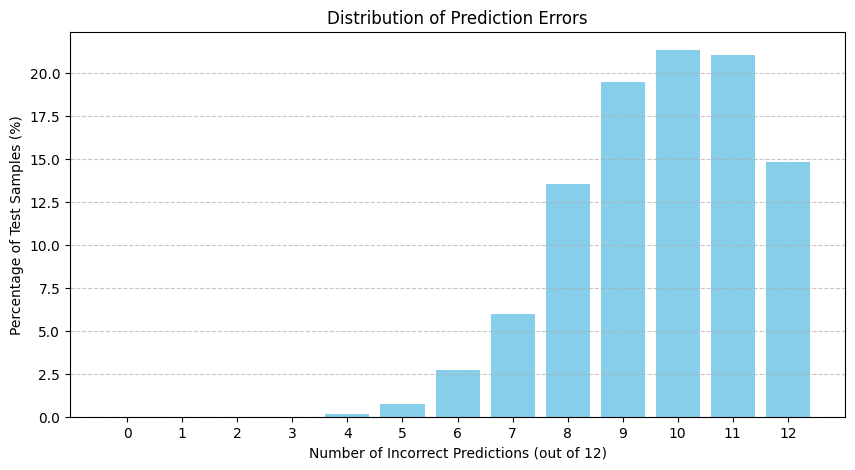

0 errors: 0.00%
1 errors: 0.00%
2 errors: 0.00%
3 errors: 0.01%
4 errors: 0.18%
5 errors: 0.75%
6 errors: 2.73%
7 errors: 6.01%
8 errors: 13.56%
9 errors: 19.47%
10 errors: 21.35%
11 errors: 21.07%
12 errors: 14.85%


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt


model.eval()
errors = []

batch_size = 10000  # Process test data in smaller batches to avoid memory spikes
num_batches = len(X_test_tensor) // batch_size + 1

def count_errors(pred, true, tolerance=1e-3):
    return np.sum(np.abs(pred - true) > tolerance)

error_counts = np.zeros(13, dtype=int)  # Stores count of cases with 0 to 12 errors

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(X_test_tensor))

    with torch.no_grad():
        test_outputs_batch = model(X_test_tensor[start_idx:end_idx].to(device)).cpu().numpy()
        ground_truth_batch = Y_test_tensor[start_idx:end_idx].cpu().numpy()

        for pred, true in zip(test_outputs_batch, ground_truth_batch):
            num_errors = count_errors(pred, true)
            error_counts[num_errors] += 1

# Compute error distribution in percentages
total_samples = np.sum(error_counts)
error_percentages = (error_counts / total_samples) * 100


plt.figure(figsize=(10, 5))
plt.bar(range(13), error_percentages, color='skyblue')
plt.xlabel("Number of Incorrect Predictions (out of 12)")
plt.ylabel("Percentage of Test Samples (%)")
plt.title("Distribution of Prediction Errors")
plt.xticks(range(13))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print percentages
for i in range(13):
    print(f"{i} errors: {error_percentages[i]:.2f}%")

**Best case, Average case and Worst case predictions of 20 continuous predictions from the testset using sliding window**

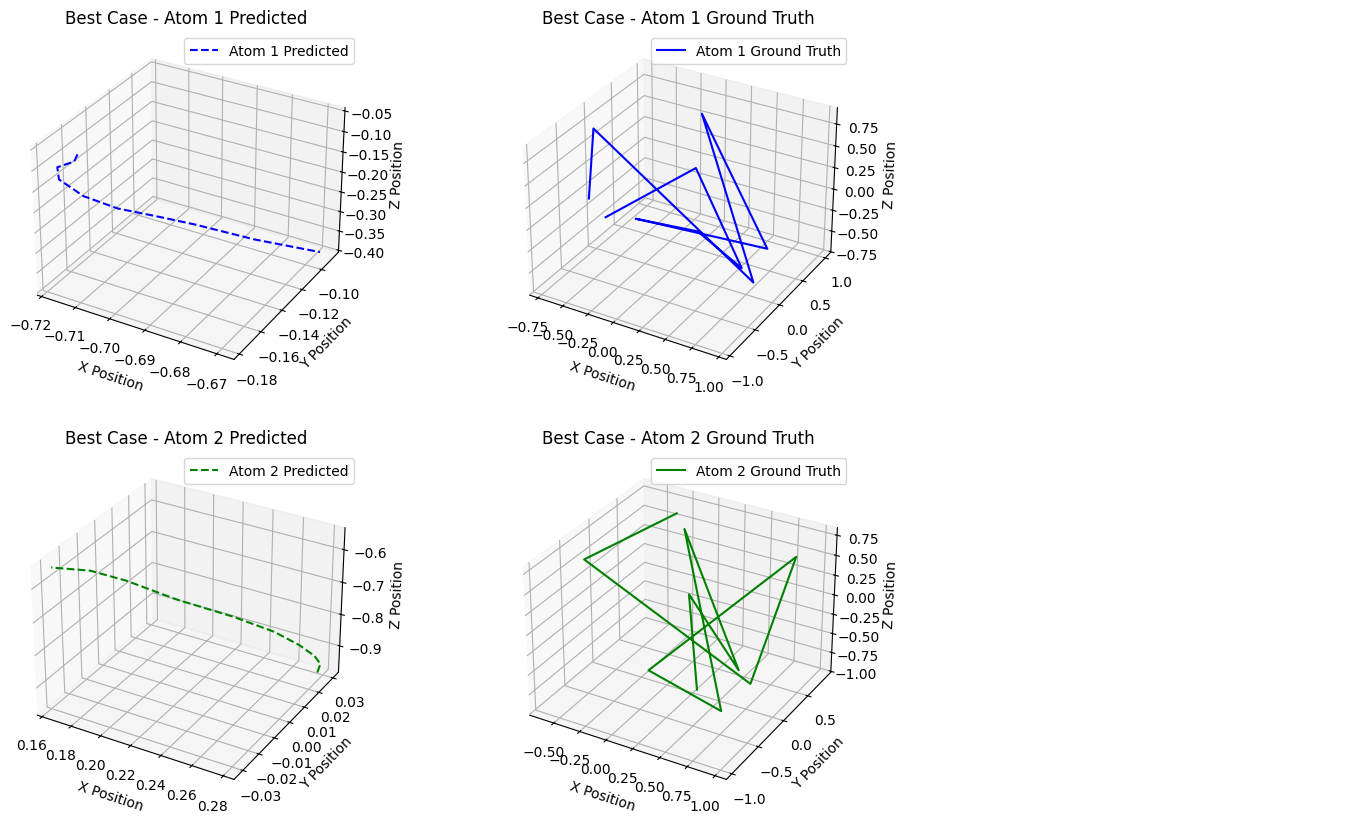

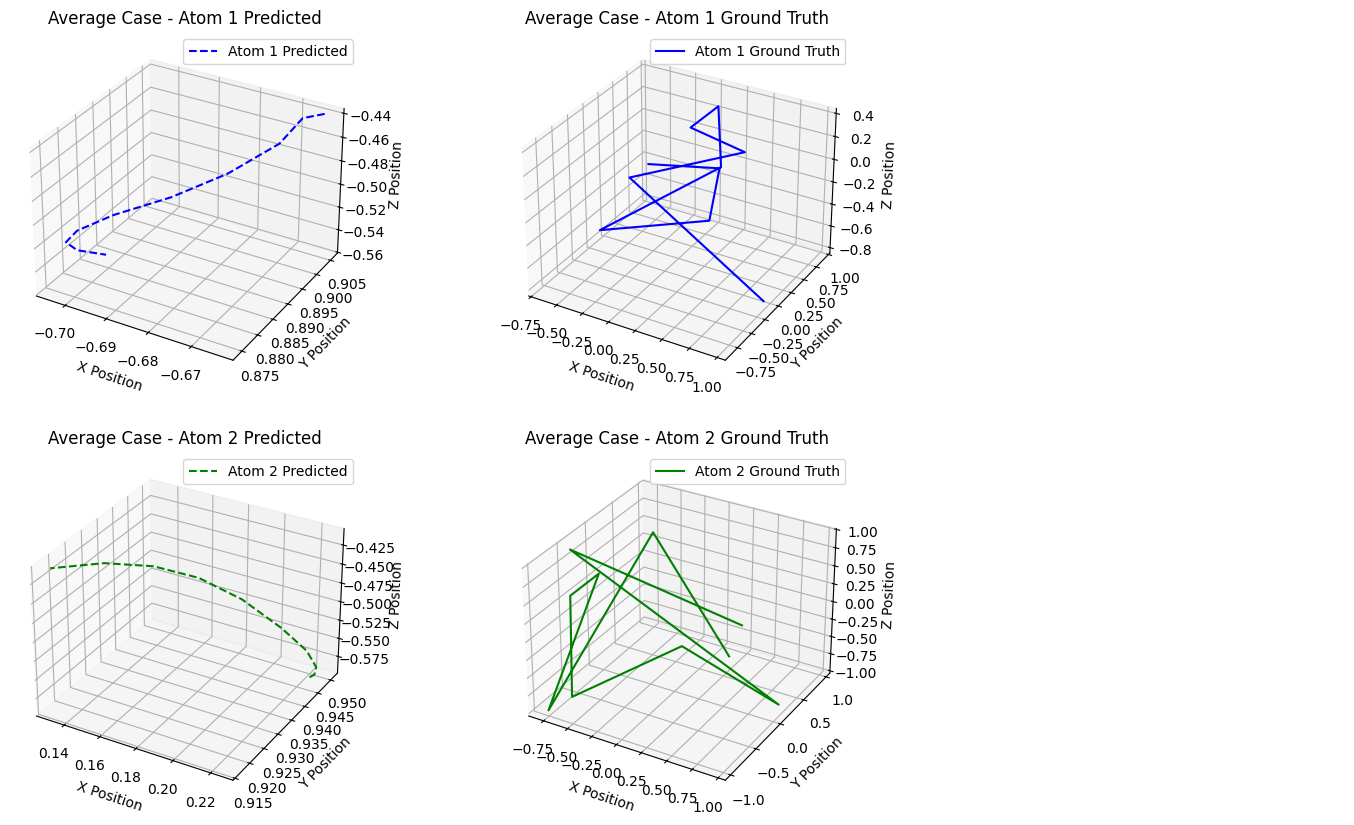

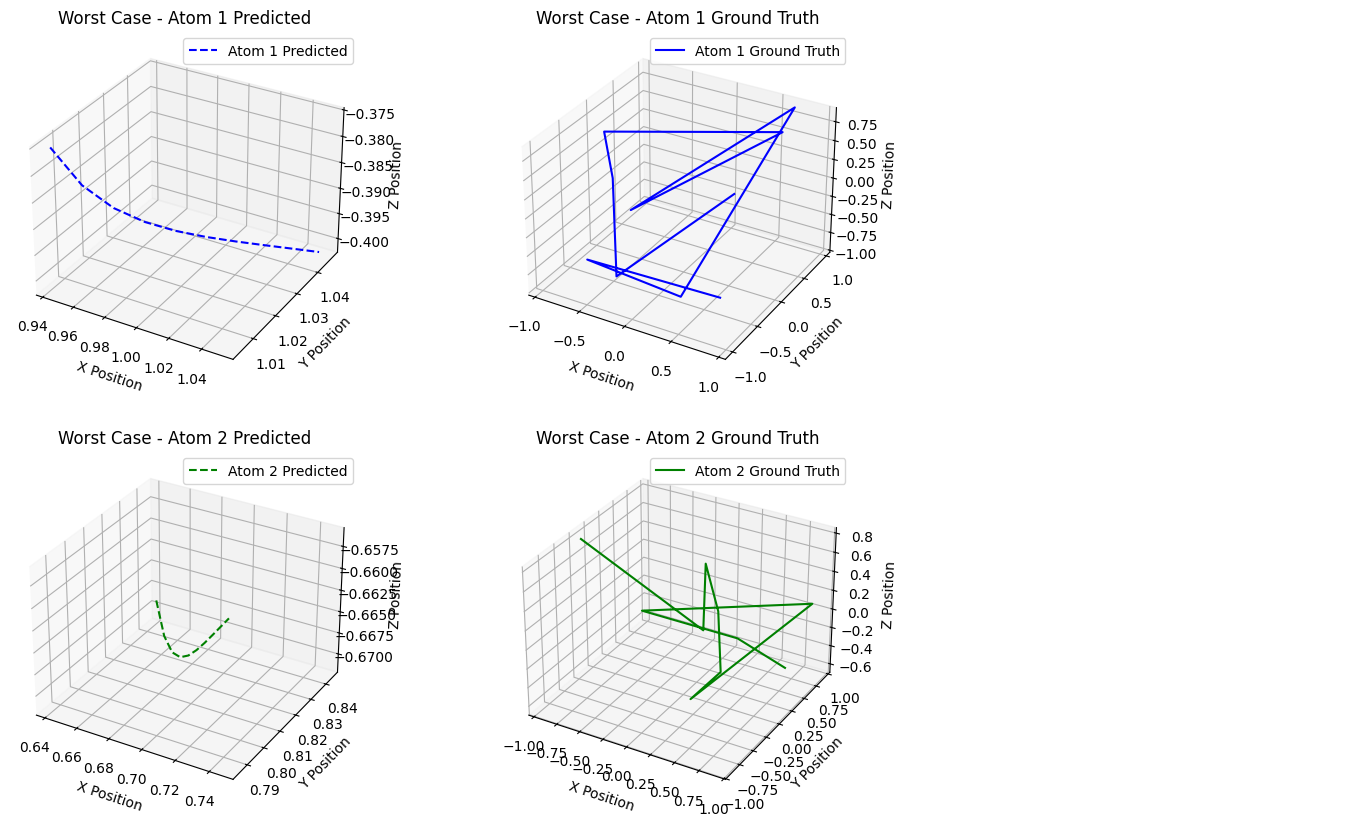

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt


def plot_separate_trajectories(idx, case_name):
    """Creates 6 separate 3D plots: Predicted and Ground Truth for both atoms."""

    num_timesteps = 10  # Predict 10 steps ahead

    # Extract ground truth trajectory for 10 timesteps
    ground_truth_positions1 = Y_test_tensor[idx:idx + num_timesteps, :3].cpu().numpy()
    ground_truth_positions2 = Y_test_tensor[idx:idx + num_timesteps, 3:6].cpu().numpy()

    # Store predicted positions
    predicted_positions1 = []
    predicted_positions2 = []

    # Initialize with first input state
    input_state = X_test_tensor[idx].unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(num_timesteps):
            prediction = model(input_state).cpu().numpy().flatten()

            # Store predicted positions
            predicted_positions1.append(prediction[:3])
            predicted_positions2.append(prediction[3:6])

            # Update input state with new prediction
            input_state = torch.tensor(prediction, dtype=torch.float32).unsqueeze(0).to(device)

    # Convert lists to NumPy arrays for plotting
    predicted_positions1 = np.array(predicted_positions1)
    predicted_positions2 = np.array(predicted_positions2)

    # Create 6 subplots: Predicted & Ground Truth for Atom 1 & Atom 2
    fig, axes = plt.subplots(2, 3, figsize=(18, 10), subplot_kw={'projection': '3d'})

    # Plot Predicted for Atom 1
    axes[0, 0].plot(predicted_positions1[:, 0], predicted_positions1[:, 1], predicted_positions1[:, 2],
                     'b--', label="Atom 1 Predicted")
    axes[0, 0].set_title(f"{case_name} - Atom 1 Predicted")
    axes[0, 0].set_xlabel("X Position")
    axes[0, 0].set_ylabel("Y Position")
    axes[0, 0].set_zlabel("Z Position")
    axes[0, 0].legend()

    # Plot Ground Truth for Atom 1
    axes[0, 1].plot(ground_truth_positions1[:, 0], ground_truth_positions1[:, 1], ground_truth_positions1[:, 2],
                     'b-', label="Atom 1 Ground Truth")
    axes[0, 1].set_title(f"{case_name} - Atom 1 Ground Truth")
    axes[0, 1].set_xlabel("X Position")
    axes[0, 1].set_ylabel("Y Position")
    axes[0, 1].set_zlabel("Z Position")
    axes[0, 1].legend()

    # Empty subplot for spacing
    axes[0, 2].axis('off')

    # Plot Predicted for Atom 2
    axes[1, 0].plot(predicted_positions2[:, 0], predicted_positions2[:, 1], predicted_positions2[:, 2],
                     'g--', label="Atom 2 Predicted")
    axes[1, 0].set_title(f"{case_name} - Atom 2 Predicted")
    axes[1, 0].set_xlabel("X Position")
    axes[1, 0].set_ylabel("Y Position")
    axes[1, 0].set_zlabel("Z Position")
    axes[1, 0].legend()

    # Plot Ground Truth for Atom 2
    axes[1, 1].plot(ground_truth_positions2[:, 0], ground_truth_positions2[:, 1], ground_truth_positions2[:, 2],
                     'g-', label="Atom 2 Ground Truth")
    axes[1, 1].set_title(f"{case_name} - Atom 2 Ground Truth")
    axes[1, 1].set_xlabel("X Position")
    axes[1, 1].set_ylabel("Y Position")
    axes[1, 1].set_zlabel("Z Position")
    axes[1, 1].legend()

    # Empty subplot for spacing
    axes[1, 2].axis('off')

    plt.show()


plot_separate_trajectories(best_idx, "Best Case")
plot_separate_trajectories(avg_idx, "Average Case")
plot_separate_trajectories(worst_idx, "Worst Case")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

dtype = torch.float32  # Using float32 for precision

# Stack position and velocity arrays to create input (X) and output (Y) datasets
X = np.hstack([positions1_array[:-1], positions2_array[:-1], velocity1_array[:-1], velocity2_array[:-1]])
Y = np.hstack([positions1_array[1:], positions2_array[1:], velocity1_array[1:], velocity2_array[1:]])

# Normalize using Min-Max Scaling
scaler_X = MinMaxScaler(feature_range=(-1, 1))  # Scale to [-1, 1] for stable training
scaler_Y = MinMaxScaler(feature_range=(-1, 1))

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

# Split into 75% train and 25% test
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.25, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=dtype)
Y_train_tensor = torch.tensor(Y_train, dtype=dtype)
X_test_tensor = torch.tensor(X_test, dtype=dtype)
Y_test_tensor = torch.tensor(Y_test, dtype=dtype)

# Free up memory
del X_train, Y_train, X_test, Y_test


class TransformerTrajectoryModel(nn.Module):
    def __init__(self, input_size=12, hidden_size=128, num_layers=4, num_heads=8, output_size=12):
        super(TransformerTrajectoryModel, self).__init__()

        self.embedding = nn.Linear(input_size, hidden_size)
        self.positional_encoding = nn.Parameter(torch.zeros(1, hidden_size))

        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dim_feedforward=hidden_size * 2)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding
        x = self.transformer(x.unsqueeze(1)).squeeze(1)
        x = self.fc_out(x)
        return x

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerTrajectoryModel(input_size=12, output_size=12).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Move data to device
X_train_tensor, Y_train_tensor = X_train_tensor.to(device), Y_train_tensor.to(device)
X_test_tensor, Y_test_tensor = X_test_tensor.to(device), Y_test_tensor.to(device)

num_epochs = 30
batch_size = 1000  # Keeping memory efficient batch size
train_losses = []

# Create DataLoader for batching
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6e}")

model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, Y_test_tensor).item()

print(f"\nTest Loss: {test_loss:.6e}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/30], Loss: 6.668372e-03
Epoch [2/30], Loss: 5.578141e-04
Epoch [3/30], Loss: 3.755295e-04
Epoch [4/30], Loss: 3.235640e-04
Epoch [5/30], Loss: 3.012326e-04
Epoch [6/30], Loss: 2.949218e-04
Epoch [7/30], Loss: 2.828686e-04
Epoch [8/30], Loss: 2.753329e-04
Epoch [9/30], Loss: 2.707637e-04
Epoch [10/30], Loss: 2.683010e-04
Epoch [11/30], Loss: 2.686472e-04
Epoch [12/30], Loss: 2.612667e-04
Epoch [13/30], Loss: 2.583384e-04
Epoch [14/30], Loss: 2.610131e-04
Epoch [15/30], Loss: 2.530358e-04
Epoch [16/30], Loss: 2.526973e-04
Epoch [17/30], Loss: 2.524985e-04
Epoch [18/30], Loss: 2.494119e-04
Epoch [19/30], Loss: 2.481888e-04
Epoch [20/30], Loss: 2.476668e-04
Epoch [21/30], Loss: 2.469949e-04
Epoch [22/30], Loss: 2.462110e-04
Epoch [23/30], Loss: 2.452467e-04
Epoch [24/30], Loss: 2.435313e-04
Epoch [25/30], Loss: 2.441774e-04
Epoch [26/30], Loss: 2.432927e-04
Epoch [27/30], Loss: 2.424547e-04
Epoch [28/30], Loss: 2.422657e-04
Epoch [29/30], Loss: 2.417432e-04
Epoch [30/30], Loss: 2.

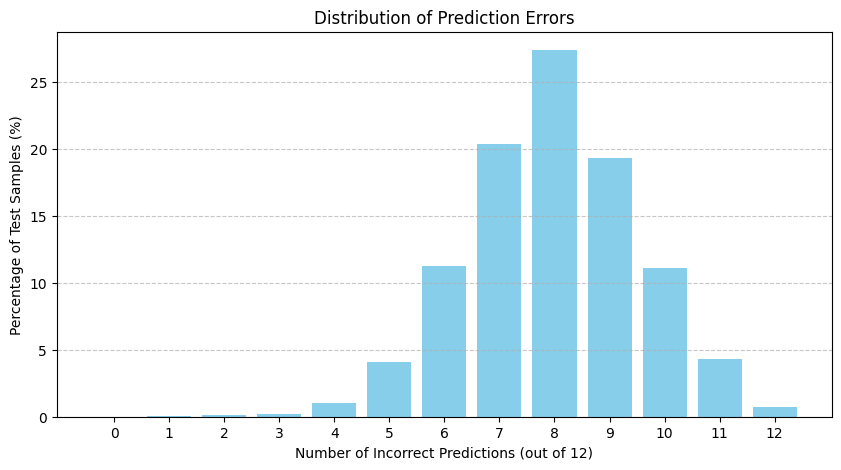

0 errors: 0.00%
1 errors: 0.03%
2 errors: 0.14%
3 errors: 0.20%
4 errors: 1.02%
5 errors: 4.06%
6 errors: 11.27%
7 errors: 20.39%
8 errors: 27.40%
9 errors: 19.34%
10 errors: 11.09%
11 errors: 4.30%
12 errors: 0.74%


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt


model.eval()
errors = []

batch_size = 10000  # Process test data in smaller batches to avoid memory spikes
num_batches = len(X_test_tensor) // batch_size + 1

def count_errors(pred, true, tolerance=1e-3):
    return np.sum(np.abs(pred - true) > tolerance)

error_counts = np.zeros(13, dtype=int)  # Stores count of cases with 0 to 12 errors

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(X_test_tensor))

    with torch.no_grad():
        test_outputs_batch = model(X_test_tensor[start_idx:end_idx].to(device)).cpu().numpy()
        ground_truth_batch = Y_test_tensor[start_idx:end_idx].cpu().numpy()

        for pred, true in zip(test_outputs_batch, ground_truth_batch):
            num_errors = count_errors(pred, true)
            error_counts[num_errors] += 1

# Compute error distribution in percentages
total_samples = np.sum(error_counts)
error_percentages = (error_counts / total_samples) * 100


plt.figure(figsize=(10, 5))
plt.bar(range(13), error_percentages, color='skyblue')
plt.xlabel("Number of Incorrect Predictions (out of 12)")
plt.ylabel("Percentage of Test Samples (%)")
plt.title("Distribution of Prediction Errors")
plt.xticks(range(13))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print percentages
for i in range(13):
    print(f"{i} errors: {error_percentages[i]:.2f}%")

**Trying a deeper neural network**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


dtype = torch.float32  # Using float32 for precision

# Stack position and velocity arrays to create input (X) and output (Y) datasets
X = np.hstack([positions1_array[:-1], positions2_array[:-1], velocity1_array[:-1], velocity2_array[:-1]])
Y = np.hstack([positions1_array[1:], positions2_array[1:], velocity1_array[1:], velocity2_array[1:]])

# Normalize using Min-Max Scaling
scaler_X = MinMaxScaler(feature_range=(-1, 1))  # Scale to [-1, 1] for stable training
scaler_Y = MinMaxScaler(feature_range=(-1, 1))

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

# Split into 75% train and 25% test
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.25, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=dtype)
Y_train_tensor = torch.tensor(Y_train, dtype=dtype)
X_test_tensor = torch.tensor(X_test, dtype=dtype)
Y_test_tensor = torch.tensor(Y_test, dtype=dtype)

# Free up memory
del X_train, Y_train, X_test, Y_test


class DeepFFN(nn.Module):
    def __init__(self, input_size=12, hidden_size=512, output_size=12):
        super(DeepFFN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc_out(x)
        return x

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepFFN(input_size=12, hidden_size=512, output_size=12).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Move data to device
X_train_tensor, Y_train_tensor = X_train_tensor.to(device), Y_train_tensor.to(device)
X_test_tensor, Y_test_tensor = X_test_tensor.to(device), Y_test_tensor.to(device)


num_epochs = 30
batch_size = 64  # Keeping memory efficient batch size
train_losses = []

# Create DataLoader for batching
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6e}")


model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, Y_test_tensor).item()

print(f"\nTest Loss: {test_loss:.6e}")

Epoch [1/30], Loss: 1.135074e-03
Epoch [2/30], Loss: 3.736955e-04
Epoch [3/30], Loss: 3.185353e-04
Epoch [4/30], Loss: 2.957029e-04
Epoch [5/30], Loss: 2.859276e-04
Epoch [6/30], Loss: 2.797660e-04
Epoch [7/30], Loss: 2.729531e-04
Epoch [8/30], Loss: 2.690544e-04
Epoch [9/30], Loss: 2.659835e-04
Epoch [10/30], Loss: 2.640966e-04
Epoch [11/30], Loss: 2.615125e-04
Epoch [12/30], Loss: 2.614641e-04
Epoch [13/30], Loss: 2.588259e-04
Epoch [14/30], Loss: 2.568589e-04
Epoch [15/30], Loss: 2.578744e-04
Epoch [16/30], Loss: 2.571113e-04
Epoch [17/30], Loss: 2.576112e-04
Epoch [18/30], Loss: 2.556997e-04
Epoch [19/30], Loss: 2.571853e-04
Epoch [20/30], Loss: 2.583363e-04
Epoch [21/30], Loss: 2.557925e-04
Epoch [22/30], Loss: 2.531168e-04
Epoch [23/30], Loss: 2.536283e-04
Epoch [24/30], Loss: 2.538675e-04
Epoch [25/30], Loss: 2.534726e-04
Epoch [26/30], Loss: 2.526646e-04
Epoch [27/30], Loss: 2.539351e-04
Epoch [28/30], Loss: 2.555970e-04
Epoch [29/30], Loss: 2.511524e-04
Epoch [30/30], Loss: 2.